In [19]:
%%capture
!pip install cvxpy pennylane

In [10]:
import numpy as np
import cvxpy as cp
import scipy as sc
import pennylane as qml
import time
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.optim as optim
from torch.autograd import Variable

In [11]:
import sys
print(sys.executable)

/home/mitsukism/myenv/bin/python


## [Original] PennyLane implementation

### Circuits

In [12]:
# quantum circuit settings
num_qubits = 2
num_wires = 2 * num_qubits
num_layers = 3

# dimension of the system
N = 2 ** num_qubits

# initiate the quantum device
device = qml.device("default.qubit", wires=num_wires)

# initialize the parameters of a unitary that we will apply
# to rho and sigma
# For the case of von neumann entropy, sigma is maximally mixed state.
# Therefore, for that, we can just use a uniform number generator for sampling

@qml.qnode(device)
def measure_rho(param):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.PauliZ(wires=0)
    qml.PauliX(wires=0)
    qml.PauliY(wires=1)

    # Apply the parameterized unitary to it
    qml.RandomLayers(param, wires=[0, 1])
    return qml.density_matrix(wires=[2,3])

def claculate_entropy(rho):
    sigma = np.eye(N) / N
    np.seterr(divide='ignore', invalid='ignore')
    H_rho = np.real(np.trace(rho @ (sc.linalg.logm(rho) - sc.linalg.logm(sigma))))
    np.seterr(divide = 'warn', invalid='warn')
    return H_rho

param = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))
print(claculate_entropy(measure_rho(param)))

0.6931471805599446


/home/mitsukism/myenv/lib/python3.12/site-packages/scipy/linalg/_matfuncs.py:200: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  F = scipy.linalg._matfuncs_inv_ssq._logm(A)


In [13]:
# quantum circuit settings
num_wires = 4
num_layers = 3
num_of_samples = 100

# dimension of the system
N = 4

# initiate the quantum device
device = qml.device("default.qubit", wires=num_wires, shots=num_of_samples)

@qml.qnode(device)
def measure_rho(param):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.PauliZ(wires=0)
    qml.PauliX(wires=0)
    qml.PauliY(wires=1)

    # Apply the parameterized unitary to it
    qml.RandomLayers(param, wires=[0, 1])
    # return qml.density_matrix(wires=[0, 1])

    # measure in the computational basis
    result = qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
    return result

param = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))
z0_samlpes, z1_samples = measure_rho(param)

In [14]:
class neural_function(nn.Module):
    def __init__(self,dimension,hidden_layer):
        super(neural_function, self).__init__()

        self.dimension = dimension
        self.hidden_layer = hidden_layer
        self.lin1 = nn.Linear(self.dimension, self.hidden_layer)
        self.lin_end = nn.Linear(self.hidden_layer, 1)

    def forward(self, input):
        y = torch.sigmoid(self.lin1(input.float()))
        y = self.lin_end(y)

        return y

### PennyLane Implementation with Neural Network

In [17]:
qubits=2

In [15]:
#@title Optimization using Gradient Descent (with neural network)

# parameters of the optimization
num_of_epochs = 1000
learning_rate = 0.05
num_of_samples = 100
dimension = 2
hidden_layer = 10

# initiate the quantum device
device = qml.device("default.qubit", wires=num_wires, shots=num_of_samples)

@qml.qnode(device)
def measure_rho(param):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.PauliZ(wires=0)
    qml.PauliX(wires=0)
    qml.PauliY(wires=1)

    # Apply the parameterized unitary to it
    qml.RandomLayers(param, wires=[0, 1])
    # return qml.density_matrix(wires=[0, 1])

    # measure in the computational basis
    result = qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
    return result
    
np.random.seed(42)

# initialize the neural network and quantum circuit parameters
neural_fn = neural_function(dimension, hidden_layer)
param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))
# intialize the cost function store
cost_func_store = []

# start the training
for epoch in range(1, num_of_epochs):

  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                forward_sum += nn_result[0].detach().numpy()

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                backward_sum += nn_result[0].detach().numpy()

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

  # evaluate the gradient with respect to the NN parameters
    optimizer = optim.SGD(neural_fn.parameters(), lr=learning_rate)

  # evaluate the first term
    loss = 0
    result = measure_rho(prev_param_init)
    for sample in range(num_of_samples):
        # optimizer.zero_grad()
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        random_result_array = np.random.choice([-1, 1], size=2)
        sample_nn_result = neural_fn(torch.from_numpy(sample_result_array))
        random_nn_result = neural_fn(torch.from_numpy(random_result_array))
        loss_term = (torch.exp(random_nn_result[0]) - sample_nn_result[0]).to("cpu")
        loss += loss_term / num_of_samples
    loss.backward()
    torch.nn.utils.clip_grad_norm_(neural_fn.parameters(), max_norm=1.0)
    optimizer.step()

  # evaluate the cost function at these parameters
    first_term = 0
    result = measure_rho(param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        first_term += nn_result[0].detach().numpy()

  # normalize the cost sum
    first_term = first_term/num_of_samples

  # # Second term evaluation
    second_term = 0
    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        second_term += np.exp(nn_result[0].detach().numpy())

  # normalize the second term sum
    second_term = second_term/num_of_samples

    # add the cost function to the store
    cost_func_store.append(np.log(N) - first_term + second_term - 1)

  # print the cost
    print(f"Epoch {epoch}: Loss: {loss.item()} Cost: {np.log(N) - first_term + second_term - 1}")

Epoch 1: Loss: 1.0917775630950928 Cost: 1.4740501264387609
Epoch 2: Loss: 1.081954836845398 Cost: 1.4394171354824548
Epoch 3: Loss: 1.0471138954162598 Cost: 1.4064147495383263
Epoch 4: Loss: 1.0192986726760864 Cost: 1.3982691732698918
Epoch 5: Loss: 1.001976490020752 Cost: 1.3959465890282634
Epoch 6: Loss: 0.9917039275169373 Cost: 1.38414710498395
Epoch 7: Loss: 1.0084329843521118 Cost: 1.4024654305631161
Epoch 8: Loss: 0.998720109462738 Cost: 1.400229834383154
Epoch 9: Loss: 1.0388928651809692 Cost: 1.4108667199963572
Epoch 10: Loss: 1.0368276834487915 Cost: 1.407470613037968
Epoch 11: Loss: 1.0184781551361084 Cost: 1.40039578861537
Epoch 12: Loss: 0.9954829216003418 Cost: 1.3879181799942497
Epoch 13: Loss: 0.9905572533607483 Cost: 1.3927630365544799
Epoch 14: Loss: 0.9903777241706848 Cost: 1.3911804304176814
Epoch 15: Loss: 1.001814842224121 Cost: 1.3887699372226243
Epoch 16: Loss: 1.018510341644287 Cost: 1.4010080098265654
Epoch 17: Loss: 1.017612099647522 Cost: 1.4094937253648285
E

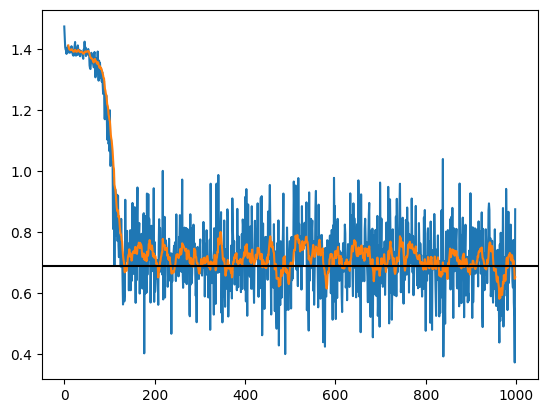

In [20]:
import matplotlib.pyplot as plt
import pandas as pd # import the pandas library

plt.plot(cost_func_store, label = "Cost function")
plt.plot(pd.Series(cost_func_store).rolling(window=10).mean(), label = "Moving average") # Call Series from the pandas library
plt.axhline(0.69, color='black')
plt.savefig(f"/home/mitsukism/qiskit_entropy/vn_net_cost/qubits2/cost_qubits{qubits}_sample{num_of_samples}_process.png")
plt.show()

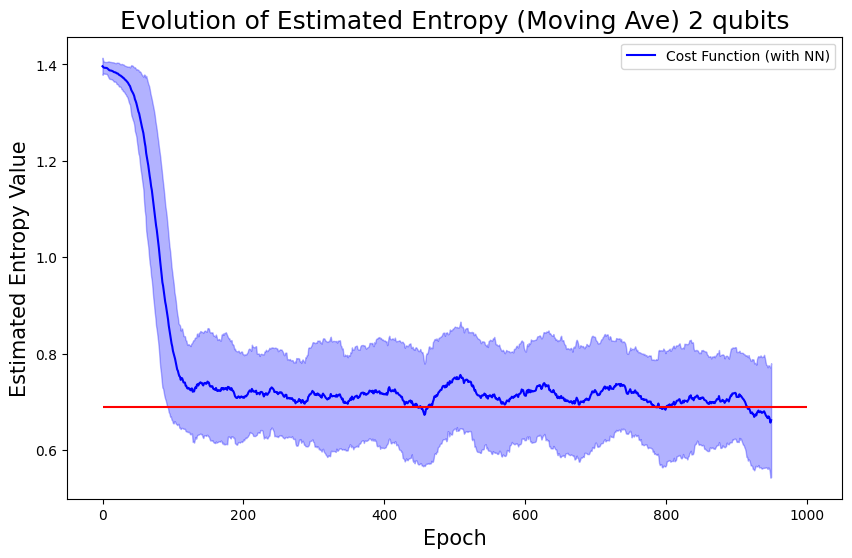

In [22]:
# 移動平均を計算する関数を定義
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 移動平均と標準偏差を計算
window_size = 50  # ウィンドウサイズを50とする
rolling_mean = moving_average(cost_func_store, window_size)
rolling_std = np.std([cost_func_store[i:i+window_size] for i in range(len(cost_func_store)-window_size+1)], axis=1)

# グラフの描画
plt.figure(figsize=(10, 6))

# 移動平均のプロット
plt.plot(rolling_mean, label='Cost Function (with NN)', color='blue', linewidth=1.5)

# 標準偏差を基に塗りつぶしを追加
plt.fill_between(range(len(rolling_mean)), rolling_mean - rolling_std, rolling_mean + rolling_std, color='blue', alpha=0.3)

# 軸ラベルとタイトルを追加
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Estimated Entropy Value', fontsize=15)
plt.title('Evolution of Estimated Entropy (Moving Ave) 2 qubits', fontsize=18)
plt.hlines(0.69, 0, num_of_epochs, color='red')

# 凡例の追加
plt.legend()

plt.savefig(f"/home/mitsukism/qiskit_entropy/vn_net_cost/qubits2/cost_qubits{qubits}_sample{num_of_samples}_process.png")

# グラフを表示
plt.show()

In [23]:
#@title Optimization using Gradient Descent (with neural network)

# parameters of the optimization
num_of_epochs = 1000
learning_rate = 0.05
num_of_samples = 1000
dimension = 2
hidden_layer = 10

# initiate the quantum device
device = qml.device("default.qubit", wires=num_wires, shots=num_of_samples)

@qml.qnode(device)
def measure_rho(param):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.PauliZ(wires=0)
    qml.PauliX(wires=0)
    qml.PauliY(wires=1)

    # Apply the parameterized unitary to it
    qml.RandomLayers(param, wires=[0, 1])
    # return qml.density_matrix(wires=[0, 1])

    # measure in the computational basis
    result = qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
    return result
    
np.random.seed(42)

# initialize the neural network and quantum circuit parameters
neural_fn = neural_function(dimension, hidden_layer)
param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))
# intialize the cost function store
cost_func_store = []

# start the training
for epoch in range(1, num_of_epochs):

  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                forward_sum += nn_result[0].detach().numpy()

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                backward_sum += nn_result[0].detach().numpy()

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

  # evaluate the gradient with respect to the NN parameters
    optimizer = optim.SGD(neural_fn.parameters(), lr=learning_rate)

  # evaluate the first term
    loss = 0
    result = measure_rho(prev_param_init)
    for sample in range(num_of_samples):
        # optimizer.zero_grad()
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        random_result_array = np.random.choice([-1, 1], size=2)
        sample_nn_result = neural_fn(torch.from_numpy(sample_result_array))
        random_nn_result = neural_fn(torch.from_numpy(random_result_array))
        loss_term = (torch.exp(random_nn_result[0]) - sample_nn_result[0]).to("cpu")
        loss += loss_term / num_of_samples
    loss.backward()
    torch.nn.utils.clip_grad_norm_(neural_fn.parameters(), max_norm=1.0)
    optimizer.step()

  # evaluate the cost function at these parameters
    first_term = 0
    result = measure_rho(param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        first_term += nn_result[0].detach().numpy()

  # normalize the cost sum
    first_term = first_term/num_of_samples

  # # Second term evaluation
    second_term = 0
    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        second_term += np.exp(nn_result[0].detach().numpy())

  # normalize the second term sum
    second_term = second_term/num_of_samples

    # add the cost function to the store
    cost_func_store.append(np.log(N) - first_term + second_term - 1)

  # print the cost
    print(f"Epoch {epoch}: Loss: {loss.item()} Cost: {np.log(N) - first_term + second_term - 1}")

Epoch 1: Loss: 1.09859037399292 Cost: 1.446559253727818
Epoch 2: Loss: 1.0664422512054443 Cost: 1.4215607511604071
Epoch 3: Loss: 1.0331451892852783 Cost: 1.4030303079986814
Epoch 4: Loss: 1.0172299146652222 Cost: 1.403031218288267
Epoch 5: Loss: 1.0047917366027832 Cost: 1.3853008031079415
Epoch 6: Loss: 1.0066810846328735 Cost: 1.4004867430681234
Epoch 7: Loss: 1.0166046619415283 Cost: 1.4123106705898287
Epoch 8: Loss: 1.0232962369918823 Cost: 1.4117791173661
Epoch 9: Loss: 1.028731346130371 Cost: 1.411084277292514
Epoch 10: Loss: 1.0310128927230835 Cost: 1.4114013171473387
Epoch 11: Loss: 1.0205050706863403 Cost: 1.4004052820706612
Epoch 12: Loss: 1.0118032693862915 Cost: 1.3928262510204559
Epoch 13: Loss: 1.0032520294189453 Cost: 1.390502900874043
Epoch 14: Loss: 1.0042145252227783 Cost: 1.393129708809579
Epoch 15: Loss: 1.005245327949524 Cost: 1.4036250881010535
Epoch 16: Loss: 1.012978196144104 Cost: 1.4058901202434546
Epoch 17: Loss: 1.0214217901229858 Cost: 1.404164192234898
Epo

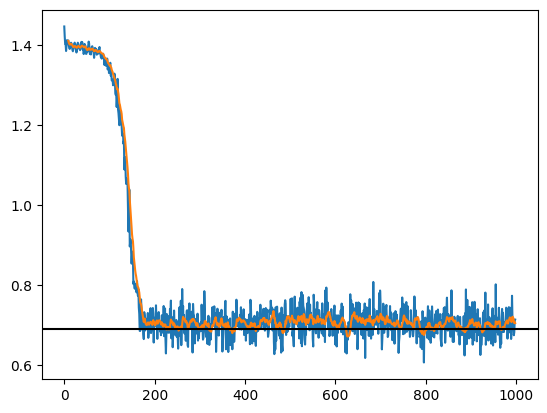

In [24]:
import matplotlib.pyplot as plt
import pandas as pd # import the pandas library

plt.plot(cost_func_store, label = "Cost function")
plt.plot(pd.Series(cost_func_store).rolling(window=10).mean(), label = "Moving average") # Call Series from the pandas library
plt.axhline(0.69, color='black')
plt.savefig(f"/home/mitsukism/qiskit_entropy/vn_net_cost/qubits2/cost_qubits{qubits}_sample{num_of_samples}_process.png")
plt.show()

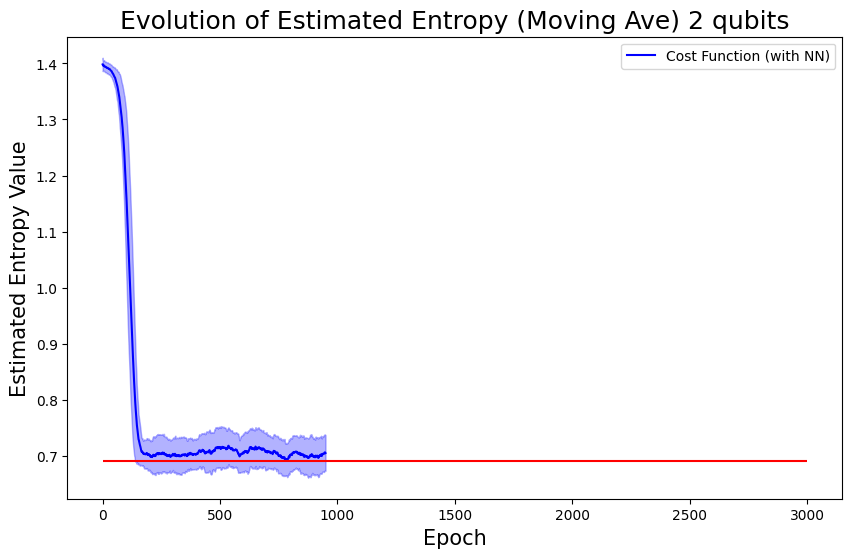

In [25]:
# 移動平均を計算する関数を定義
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 移動平均と標準偏差を計算
window_size = 50  # ウィンドウサイズを50とする
rolling_mean = moving_average(cost_func_store, window_size)
rolling_std = np.std([cost_func_store[i:i+window_size] for i in range(len(cost_func_store)-window_size+1)], axis=1)

# グラフの描画
plt.figure(figsize=(10, 6))

# 移動平均のプロット
plt.plot(rolling_mean, label='Cost Function (with NN)', color='blue', linewidth=1.5)

# 標準偏差を基に塗りつぶしを追加
plt.fill_between(range(len(rolling_mean)), rolling_mean - rolling_std, rolling_mean + rolling_std, color='blue', alpha=0.3)

# 軸ラベルとタイトルを追加
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Estimated Entropy Value', fontsize=15)
plt.title('Evolution of Estimated Entropy (Moving Ave) 2 qubits', fontsize=18)
plt.hlines(0.69, 0, num_of_epochs, color='red')

# 凡例の追加
plt.legend()

plt.savefig(f"/home/mitsukism/qiskit_entropy/vn_net_cost/qubits2/cost_qubits{qubits}_sample{num_of_samples}_process.png")

# グラフを表示
plt.show()

In [ ]:
#@title Optimization using Gradient Descent (with neural network)

# parameters of the optimization
num_of_epochs = 1000
learning_rate = 0.05
num_of_samples = 10000
dimension = 2
hidden_layer = 10

# initiate the quantum device
device = qml.device("default.qubit", wires=num_wires, shots=num_of_samples)

@qml.qnode(device)
def measure_rho(param):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.PauliZ(wires=0)
    qml.PauliX(wires=0)
    qml.PauliY(wires=1)

    # Apply the parameterized unitary to it
    qml.RandomLayers(param, wires=[0, 1])
    # return qml.density_matrix(wires=[0, 1])

    # measure in the computational basis
    result = qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
    return result
    
np.random.seed(42)

# initialize the neural network and quantum circuit parameters
neural_fn = neural_function(dimension, hidden_layer)
param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))
# intialize the cost function store
cost_func_store = []

# start the training
for epoch in range(1, num_of_epochs):

  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                forward_sum += nn_result[0].detach().numpy()

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                backward_sum += nn_result[0].detach().numpy()

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

  # evaluate the gradient with respect to the NN parameters
    optimizer = optim.SGD(neural_fn.parameters(), lr=learning_rate)

  # evaluate the first term
    loss = 0
    result = measure_rho(prev_param_init)
    for sample in range(num_of_samples):
        # optimizer.zero_grad()
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        random_result_array = np.random.choice([-1, 1], size=2)
        sample_nn_result = neural_fn(torch.from_numpy(sample_result_array))
        random_nn_result = neural_fn(torch.from_numpy(random_result_array))
        loss_term = (torch.exp(random_nn_result[0]) - sample_nn_result[0]).to("cpu")
        loss += loss_term / num_of_samples
    loss.backward()
    torch.nn.utils.clip_grad_norm_(neural_fn.parameters(), max_norm=1.0)
    optimizer.step()

  # evaluate the cost function at these parameters
    first_term = 0
    result = measure_rho(param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        first_term += nn_result[0].detach().numpy()

  # normalize the cost sum
    first_term = first_term/num_of_samples

  # # Second term evaluation
    second_term = 0
    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        second_term += np.exp(nn_result[0].detach().numpy())

  # normalize the second term sum
    second_term = second_term/num_of_samples

    # add the cost function to the store
    cost_func_store.append(np.log(N) - first_term + second_term - 1)

  # print the cost
    print(f"Epoch {epoch}: Loss: {loss.item()} Cost: {np.log(N) - first_term + second_term - 1}")

Epoch 1: Loss: 1.1804550886154175 Cost: 1.5239347824388982
Epoch 2: Loss: 1.137343168258667 Cost: 1.4841461153114084
Epoch 3: Loss: 1.0976160764694214 Cost: 1.4497923403972628
Epoch 4: Loss: 1.063692569732666 Cost: 1.4217027901107313
Epoch 5: Loss: 1.0361865758895874 Cost: 1.4014795229339843
Epoch 6: Loss: 1.0160316228866577 Cost: 1.3888697753695642
Epoch 7: Loss: 1.002867579460144 Cost: 1.3860480828134216
Epoch 8: Loss: 0.9989786148071289 Cost: 1.3904728104540949
Epoch 9: Loss: 1.0026309490203857 Cost: 1.401110125590289
Epoch 10: Loss: 1.0160300731658936 Cost: 1.40908704048785
Epoch 11: Loss: 1.0256931781768799 Cost: 1.4086724949890614
Epoch 12: Loss: 1.0216097831726074 Cost: 1.3984101789781693
Epoch 13: Loss: 1.0108826160430908 Cost: 1.388451687926227
Epoch 14: Loss: 1.001899242401123 Cost: 1.3850495847536122
Epoch 15: Loss: 0.9982179403305054 Cost: 1.3899691756257657
Epoch 16: Loss: 1.003954529762268 Cost: 1.400604326274419
Epoch 17: Loss: 1.0148216485977173 Cost: 1.4073843157315498

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd # import the pandas library

plt.plot(cost_func_store, label = "Cost function")
plt.plot(pd.Series(cost_func_store).rolling(window=10).mean(), label = "Moving average") # Call Series from the pandas library
plt.axhline(0.69, color='black')
plt.savefig(f"/home/mitsukism/qiskit_entropy/vn_net_cost/qubits2/cost_qubits{qubits}_sample{num_of_samples}_process.png")
plt.show()

In [ ]:
# 移動平均を計算する関数を定義
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 移動平均と標準偏差を計算
window_size = 50  # ウィンドウサイズを50とする
rolling_mean = moving_average(cost_func_store, window_size)
rolling_std = np.std([cost_func_store[i:i+window_size] for i in range(len(cost_func_store)-window_size+1)], axis=1)

# グラフの描画
plt.figure(figsize=(10, 6))

# 移動平均のプロット
plt.plot(rolling_mean, label='Cost Function (with NN)', color='blue', linewidth=1.5)

# 標準偏差を基に塗りつぶしを追加
plt.fill_between(range(len(rolling_mean)), rolling_mean - rolling_std, rolling_mean + rolling_std, color='blue', alpha=0.3)

# 軸ラベルとタイトルを追加
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Estimated Entropy Value', fontsize=15)
plt.title('Evolution of Estimated Entropy (Moving Ave) 2 qubits', fontsize=18)
plt.hlines(0.69, 0, num_of_epochs, color='red')

# 凡例の追加
plt.legend()

plt.savefig(f"/home/mitsukism/qiskit_entropy/vn_net_cost/qubits2/cost_qubits{qubits}_sample{num_of_samples}_process.png")

# グラフを表示
plt.show()

### PennyLane Implementation without Neural Network

In [ ]:
#@title Optimization using Gradient Descent (without neural network)

# parameters of the optimization
num_of_epochs = 1000
learning_rate = 0.08
num_of_samples = 100
deviation = 1

# initialize the neural network and quantum circuit parameters
W = deviation*np.random.rand(3,3)
np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))

# intialize the cost function store
cost_func_store = []


# start the training
for epoch in range(1, num_of_epochs):

  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                forward_sum += W[result[0][sample]][result[1][sample]]

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                backward_sum += W[result[0][sample]][result[1][sample]]

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

  # evaluate the gradient with respect to the NN parameters


  # evaluate the gradient with respect to the eigenvalues

  # 1 , 1
    E = np.zeros_like(W)
    E[1][1] = 1
    dW1 = 0
    result = measure_rho(prev_param_init)
    for sample in range(num_of_samples):
        dW1 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW1 = dW1/num_of_samples
    dW1 += (np.exp(W[1][1])/N)

    # 1 , -1
    E = np.zeros_like(W)
    E[1][-1] = 1
    dW2 = 0
    result = measure_rho(prev_param_init)
    for sample in range(num_of_samples):
        dW2 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW2 = dW2/num_of_samples
    dW2 += (np.exp(W[1][-1])/N)

    # -1 , 1
    E = np.zeros_like(W)
    E[-1][1] = 1
    dW3 = 0
    result = measure_rho(prev_param_init)
    for sample in range(num_of_samples):
        dW3 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW3 = dW3/num_of_samples
    dW3 += (np.exp(W[-1][1])/N)

    # -1 , -1
    E = np.zeros_like(W)
    E[-1][-1] = 1
    dW4 = 0
    result = measure_rho(prev_param_init)
    for sample in range(num_of_samples):
        dW4 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW4 = dW4/num_of_samples
    dW4 += (np.exp(W[-1][-1])/N)


    # update the eigenvalues
    W[1][1] -= learning_rate*dW1
    W[1][-1] -= learning_rate*dW2
    W[-1][1] -= learning_rate*dW3
    W[-1][-1] -= learning_rate*dW4

    # evaluate the cost function at these parameters
    first_term = 0
    result = measure_rho(param_init)
    for sample in range(num_of_samples):
        first_term += W[result[0][sample]][result[1][sample]]

    # normalize the cost sum
    first_term = first_term/num_of_samples

    # # Second term evaluation
    second_term = np.exp(W[1][1]) + np.exp(W[1][-1]) + np.exp(W[-1][1]) + np.exp(W[-1][-1])

    # normalize the second term sum
    second_term = second_term/N

    # add the cost function to the store
    cost_func_store.append(np.log(N) - first_term + second_term - 1)

    # print the cost
    print(np.log(N) - first_term + second_term - 1)

## Qiskit Implementation

### importing modules

In [ ]:
%%capture
%matplotlib inline

!pip install qiskit qiskit-aer qiskit-aqua pylatexenc pandas

In [ ]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.circuit import Parameter
from qiskit.quantum_info import random_unitary
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix, partial_trace
from qiskit_aer import AerSimulator
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.optim as optim
from torch.autograd import Variable
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Circuits

In [ ]:
num_wires = 4
num_layers = 3
num_shots = 100
num_rotations = 3

# Dimension of the system
N = 4

simulator = AerSimulator(method='statevector')

qc = QuantumCircuit(num_wires)

qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.z(0)
qc.x(0)
qc.y(1)

param = np.random.random((num_layers, num_rotations))

parameters = [[Parameter(f'θ_{layer}_{rot}') for rot in range(num_rotations)] for layer in range(num_layers)]

qc.ry(parameters[0][0], 0)
qc.rx(parameters[0][1], 1)
qc.cz(0, 1)
qc.rz(parameters[0][2], 1)
qc.cz(1, 0)
qc.rx(parameters[1][0], 1)
qc.ry(parameters[1][1], 1)
qc.ry(parameters[1][2], 0)
qc.rz(parameters[2][0], 0)  
qc.rz(parameters[2][1], 1)
qc.rz(parameters[2][2], 0)

param_dict = {parameters[layer][rot]: param[layer][rot] for layer in range(num_layers) for rot in range(num_rotations)}
qc = qc.assign_parameters(param_dict)

qc.save_statevector()

# Transpile and run the quantum circuit
tqc = transpile(qc, simulator)
job = simulator.run(tqc, shots=num_shots)
result = job.result()
state_vector = result.get_statevector()
counts = result.get_counts(tqc)

z0_samples = []
z1_samples = []

for key, value in counts.items():
    z0_samples.extend([int(key[-1])] * int(value * num_shots) if key[-1] == '1' else [-1] * int(value * num_shots))
    z1_samples.extend([int(key[-2])] * int(value * num_shots) if key[-2] == '1' else [-1] * int(value * num_shots))

print("Measurement results for PauliZ(0):", z0_samples)
print("Measurement results for PauliZ(1):", z1_samples)

Measurement results for PauliZ(0): [-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1]
Measurement results for PauliZ(1): [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
# param -> density matrix
from qiskit.quantum_info import Pauli, Statevector

def measure_rho(param):

    num_wires = 4
    num_layers = 3
    num_shots = 100
    num_rotations = 3

    qc = QuantumCircuit(num_wires)

    qc.h(0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    qc.z(0)
    qc.x(0)
    qc.y(1)

    parameters = [Parameter(f'θ_{i}') for i in range(num_layers*num_rotations)]
    param_dict = {parameters[i]: param[i] for i in range(num_layers*num_rotations)}

    qc.ry(parameters[0], 0)
    qc.rx(parameters[1], 1)
    qc.cz(0, 1)
    qc.rz(parameters[2], 1)
    qc.cz(1, 0)
    qc.rx(parameters[3], 1)
    qc.ry(parameters[4], 1)
    qc.ry(parameters[5], 0)
    qc.rz(parameters[6], 0)
    qc.rz(parameters[7], 1)
    qc.rz(parameters[8], 0)

    qc = qc.assign_parameters(param_dict)

    qc.save_statevector()

    tqc = transpile(qc, simulator)
    job = simulator.run(tqc, shots=num_shots)
    result = job.result()
    state_vector = result.get_statevector()

    density_matrix = DensityMatrix(state_vector)
    density_matrix = partial_trace(density_matrix, [2, 3])
    return np.array(density_matrix)

def measure_qc(param, num_wires=4, num_layers=3, num_shots=100):
    num_rotations = 3

    simulator = AerSimulator(method='statevector')

    qc = QuantumCircuit(num_wires, num_wires)

    # Define the quantum circuit
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    qc.z(0)
    qc.x(0)
    qc.y(1)

    # Add parameterized gates
    parameters = [Parameter(f'θ_{i}') for i in range(num_layers * num_rotations)]
    param_dict = {parameters[i]: param[i] for i in range(len(parameters))}

    qc.ry(parameters[0], 0)
    qc.rx(parameters[1], 1)
    qc.cz(0, 1)
    qc.rz(parameters[2], 1)
    qc.cz(1, 0)
    qc.rx(parameters[3], 1)
    qc.ry(parameters[4], 1)
    qc.ry(parameters[5], 0)
    qc.rz(parameters[6], 0)
    qc.rz(parameters[7], 1)
    qc.rz(parameters[8], 0)

    # Assign parameters and measure in Z basis for each qubit
    qc = qc.assign_parameters(param_dict)
    for i in range(num_wires):
        qc.measure(i, i)  # Measure each qubit individually

    tqc = transpile(qc, simulator)
    job = simulator.run(tqc, shots=num_shots)
    result = job.result()
    counts = result.get_counts(tqc)
    
    # Convert the counts to bitstrings representing Pauli-Z measurement results
    z0_samples = []
    z1_samples = []

    for key, value in counts.items():
        # z0_samples.extend([int(key[-1])] * int(value) if key[-1] == '1' else [-1] * int(value))
        # z1_samples.extend([int(key[-2])] * int(value) if key[-2] == '1' else [-1] * int(value))        
        z0_samples.extend([int(key[-1])] * int(value))
        z1_samples.extend([int(key[-2])] * int(value))
    
    return z0_samples, z1_samples

In [ ]:
import scipy.linalg as la
# Evaluate von Neumann entropy using its analytical forumla

# ignore the division by zero
np.seterr(divide = 'ignore')

# maximally mixed state
sigma = np.eye(N)/N

# quantum relative entropy
H_rho = np.real(np.trace(rho_test @ (la.logm(rho_test) - la.logm(sigma))))

np.seterr(divide = 'warn')

# print the result
print(np.log(N)-H_rho)

0.6931471805599458


In [ ]:
class neural_function(nn.Module):
    def __init__(self,dimension,hidden_layer):
        super(neural_function, self).__init__()

        self.dimension = dimension
        self.hidden_layer = hidden_layer
        self.lin1 = nn.Linear(self.dimension, self.hidden_layer)
        self.lin_end = nn.Linear(self.hidden_layer, 1)

    def forward(self, input):
        y = torch.sigmoid(self.lin1(input.float()))
        y = self.lin_end(y)

        return y

### Qiskit Implementation with Neaural Network

In [ ]:
#@title Optimization using Gradient Descent (with neural network)
import json

# parameters of the optimization
num_of_epochs = 500
learning_rate = 0.25
num_of_samples = 100
dimension = 2
hidden_layer = 10
num_layers = 3
num_rotations = 3

# system size
N = 4

# initialize the neural network and quantum circuit parameters
neural_fn = neural_function(dimension, hidden_layer)

# intialize the cost function store
cost_func_store = []
gradients_store = []

# Quantum circuit parameters
param_init = np.random.random(num_layers*num_rotations)
# Qiskit simulator backend
simulator = AerSimulator(method='statevector')

# Training loop
for epoch in range(1, num_of_epochs + 1):
  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros(num_layers*num_rotations)
    
    for i in range(gradients.shape[0]):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_qc(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                forward_sum += nn_result[0].detach().numpy()

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_qc(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                backward_sum += nn_result[0].detach().numpy()

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

    gradients_store.append(gradients)
    # np.save(f'./vn_net_gradients/gradients_epoch{epoch}.npy', gradients)

  # evaluate the gradient with respect to the NN parameters

  # evaluate the first term
    grad_w1 = torch.zeros_like(neural_fn.lin1.weight)
    grad_b1 = torch.zeros_like(neural_fn.lin1.bias)
    grad_w2 = torch.zeros_like(neural_fn.lin_end.weight)
    grad_b2 = torch.zeros_like(neural_fn.lin_end.bias)

    result = measure_qc(prev_param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        nn_result.backward()
        grad_w1 += neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1 += neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2 += neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2 += neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the second term
    grad_w1_2 = torch.zeros_like(neural_fn.lin1.weight.grad)
    grad_b1_2 = torch.zeros_like(neural_fn.lin1.bias.grad)
    grad_w2_2 = torch.zeros_like(neural_fn.lin_end.weight.grad)
    grad_b2_2 = torch.zeros_like(neural_fn.lin_end.bias.grad)

    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        nn_result.backward()
        grad_w1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the difference, i.e., the gradient
    nn_grad_W1 = grad_w1_2 - grad_w1
    nn_grad_b1 = grad_b1_2 - grad_b1
    nn_grad_W2 = grad_w2_2 - grad_w2
    nn_grad_b2 = grad_b2_2 - grad_b2

  # update the NN weights and normalize them
    with torch.no_grad():
        neural_fn.lin1.weight -= learning_rate*nn_grad_W1
        neural_fn.lin1.bias -= learning_rate*nn_grad_b1
        neural_fn.lin_end.weight -= learning_rate*nn_grad_W2
        neural_fn.lin_end.bias -= learning_rate*nn_grad_b2

  # evaluate the cost function at these parameters
    first_term = 0
    result = measure_qc(param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        first_term += nn_result[0].detach().numpy()

  # normalize the cost sum
    first_term = first_term/num_of_samples

  # # Second term evaluation
    second_term = 0
    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        second_term += np.exp(nn_result[0].detach().numpy())

  # normalize the second term sum
    second_term = second_term/num_of_samples

    cost_func = np.log(N) - first_term + second_term - 1

    # add the cost function to the store
    cost_func_store.append(cost_func)

    # with open(f'vn_net_param/neural_fn_params_epoch{epoch}.json', 'w') as f:
    #  json.dump(neural_fn.state_dict(), f, default=lambda x: x.tolist())

  # print the cost
    print(f"epoch: {epoch}, cost: {cost_func}")

epoch: 1, cost: 1.3674057105088475
epoch: 2, cost: 1.3395444272363428
epoch: 3, cost: 1.3150084093863015
epoch: 4, cost: 1.3281121926659587
epoch: 5, cost: 1.3168337514156345
epoch: 6, cost: 1.3379353239292149
epoch: 7, cost: 1.3204377097541338
epoch: 8, cost: 1.2841376557106021
epoch: 9, cost: 1.2741870386058336
epoch: 10, cost: 1.250572660928393
epoch: 11, cost: 1.248083320027018
epoch: 12, cost: 1.2840113637501243
epoch: 13, cost: 1.216017818962956
epoch: 14, cost: 1.2688840798193457
epoch: 15, cost: 1.1496967621797562
epoch: 16, cost: 1.2425707267874722
epoch: 17, cost: 1.213594336574698
epoch: 18, cost: 1.2452412099296097
epoch: 19, cost: 1.1390917179638391
epoch: 20, cost: 1.2569116365069393
epoch: 21, cost: 1.205333119695807
epoch: 22, cost: 1.1398625353628642
epoch: 23, cost: 1.1091219863945487
epoch: 24, cost: 1.2447752716297154
epoch: 25, cost: 1.1516218636089803
epoch: 26, cost: 1.1272031769806388
epoch: 27, cost: 1.2073004657680038
epoch: 28, cost: 1.2240570972019675
epoch:

KeyboardInterrupt: 

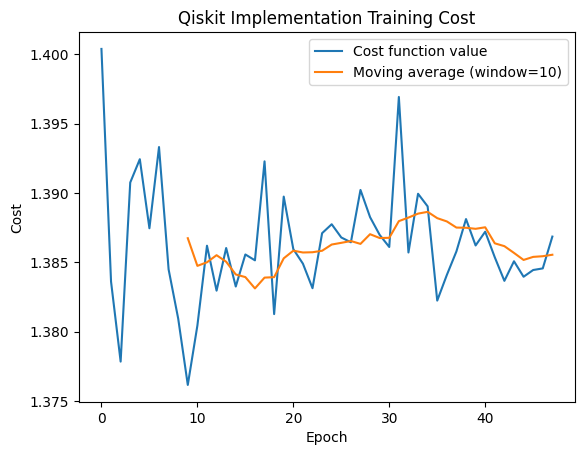

In [ ]:
# cost_func_storeの可視化
plt.plot(cost_func_store, label='Cost function value')
plt.plot(pd.Series(cost_func_store).rolling(10).mean(), label='Moving average (window=10)')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Qiskit Implementation Training Cost')
plt.legend()
plt.show()

### Qiskit Implementation without Neural Network

In [ ]:
#@title Optimization using Gradient Descent (without neural network)

# parameters of the optimization
num_of_epochs = 1000
learning_rate = 0.08
num_of_samples = 100
deviation = 1

# initialize the neural network and quantum circuit parameters
W = deviation*np.random.rand(3,3)

param_init = np.random.random(size=(num_layers, 3))

# intialize the cost function store
cost_func_store = []


# start the training
for epoch in range(1, num_of_epochs):

  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_qc(shifted)
            for sample in range(num_of_samples):
                forward_sum += W[result[0][sample]][result[1][sample]]

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_qc(shifted)
            for sample in range(num_of_samples):
                backward_sum += W[result[0][sample]][result[1][sample]]

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

  # evaluate the gradient with respect to the NN parameters


  # evaluate the gradient with respect to the eigenvalues

  # 1 , 1
    E = np.zeros_like(W)
    E[1][1] = 1
    dW1 = 0
    result = measure_qc(prev_param_init)
    for sample in range(num_of_samples):
        dW1 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW1 = dW1/num_of_samples
    dW1 += (np.exp(W[1][1])/N)

    # 1 , -1
    E = np.zeros_like(W)
    E[1][-1] = 1
    dW2 = 0
    result = measure_qc(prev_param_init)
    for sample in range(num_of_samples):
        dW2 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW2 = dW2/num_of_samples
    dW2 += (np.exp(W[1][-1])/N)

    # -1 , 1
    E = np.zeros_like(W)
    E[-1][1] = 1
    dW3 = 0
    result = measure_qc(prev_param_init)
    for sample in range(num_of_samples):
        dW3 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW3 = dW3/num_of_samples
    dW3 += (np.exp(W[-1][1])/N)

    # -1 , -1
    E = np.zeros_like(W)
    E[-1][-1] = 1
    dW4 = 0
    result = measure_qc(prev_param_init)
    for sample in range(num_of_samples):
        dW4 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW4 = dW4/num_of_samples
    dW4 += (np.exp(W[-1][-1])/N)


    # update the eigenvalues
    W[1][1] -= learning_rate*dW1
    W[1][-1] -= learning_rate*dW2
    W[-1][1] -= learning_rate*dW3
    W[-1][-1] -= learning_rate*dW4

    # evaluate the cost function at these parameters
    first_term = 0
    result = measure_qc(param_init)
    for sample in range(num_of_samples):
        first_term += W[result[0][sample]][result[1][sample]]

    # normalize the cost sum
    first_term = first_term/num_of_samples

    # # Second term evaluation
    second_term = np.exp(W[1][1]) + np.exp(W[1][-1]) + np.exp(W[-1][1]) + np.exp(W[-1][-1])

    # normalize the second term sum
    second_term = second_term/N

    # add the cost function to the store
    cost_func_store.append(np.log(N) - first_term + second_term - 1)

    # print the cost
    print(f'epoch: {epoch}, cost func: {np.log(N) - first_term + second_term - 1})

1.3827580166344156
1.3816550649494923
1.3380087367421005
1.2771333711920292
1.2515337227506222
1.2343768186906536
1.2253469906986973
1.1837224264703714
1.1676333497376064
1.1347361217156724
1.136395986213758
1.0658753087986517
1.0903928382271015
1.0502792729992936
1.0111845614227315
1.0308978739093542
0.9975798380806364
0.972100787720767
0.9413827216434578
0.9337984059680504
0.9550765538134927
0.9301366999245002
0.9222838443293353
0.903032154658606
0.8722219523876724
0.852213490536398
0.8514433084545319
0.860523324810363
0.8526663709218267
0.8197517493495889
0.8531912990610997
0.8352794799300223
0.8176405583786517
0.8161364179882258
0.8010504760624066
0.7957506693588652
0.7698573770082433
0.7597789824382928
0.7268468458040112
0.7442928083160982
0.7234712721315577
0.7372170501372015
0.7191195506903185
0.7270059546481553
0.7136355547645019
0.7020148824460213
0.6835269177237762
0.7165394064926494
0.6858309732249099
0.6786844648832955
0.6689159825906721
0.6739776047096773
0.644416357965876

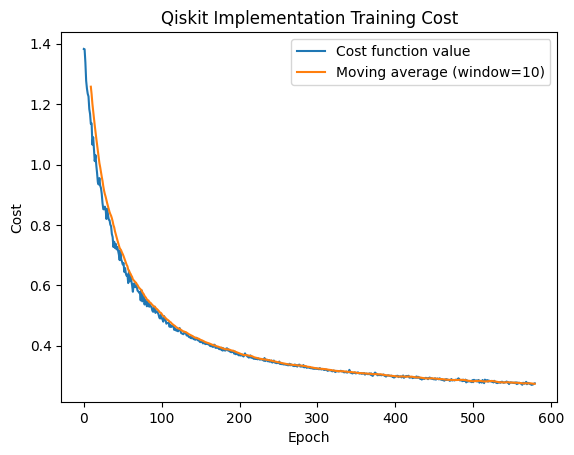

In [ ]:
# cost_func_storeの可視化
plt.plot(np.array(cost_func_store), label='Cost function value')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Qiskit Implementation Training Cost')
plt.legend()
plt.show()

"""We use Pennylane’s qml.RandomLayers subroutine to prepare a parameterized quantum circuit with a random structure and then keep this structure fixed throughout multiple runs of a specific simulation. We only change the structure when it is not sufficiently expressive, in the sense that the set of generated unitaries is not comparable to the set of all unitaries. """

### Qiskit RandomLayers

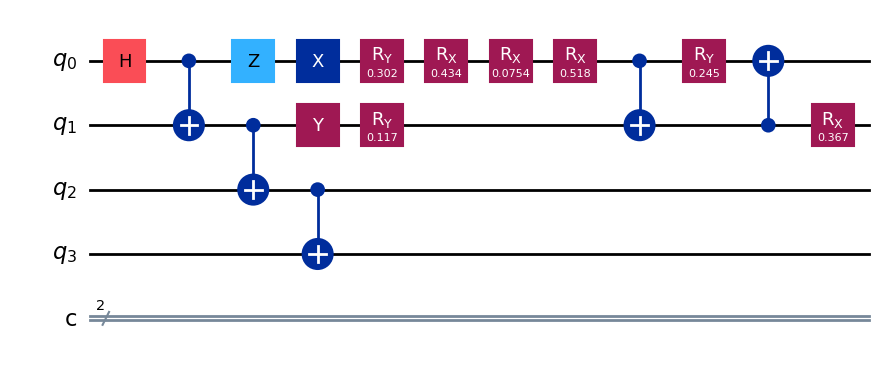

In [ ]:
from qiskit.circuit.random import random_circuit

def random_layers(param, obj_wires, num_wires, ratio_imprim=0.3, imprimitive='cx', rotations=['rx', 'ry', 'rz'], seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    num_qubits = num_wires
    circuit = QuantumCircuit(num_qubits, 2)
    shape = param.shape
    num_layers = shape[0]
    rng = np.random.default_rng(seed)

    circuit.h(0)
    circuit.cx(0, 1)
    circuit.cx(1, 2)
    circuit.cx(2, 3)
    circuit.z(0)
    circuit.x(0)
    circuit.y(1)

    for l in range(num_layers):
        i = 0
        while i < shape[1]:
            if rng.random() > ratio_imprim:
                # Apply a random single-qubit gate
                gate_choice = rng.choice(rotations)
                wire = rng.choice(obj_wires)
                if gate_choice == 'rx':
                    circuit.rx(param[l][i], wire)
                elif gate_choice == 'ry':
                    circuit.ry(param[l][i], wire)
                elif gate_choice == 'rz':
                    circuit.rz(param[l][i], wire)
            else:
                # Apply a random two-qubit gate
                if num_qubits > 1:
                    qubits = rng.choice(obj_wires, 2, replace=False)  # 選ばれた2つの異なる量子ビット
                    circuit.cx(qubits[0], qubits[1])

            i += 1  # iをインクリメント

    return circuit

# 使用例
param = np.random.random((3, 3))
wires = [0, 1]

qc = random_layers(param, wires, 4)
qc.draw('mpl')

In [ ]:
def measure_qc_random(param):
    num_wires = 4
    num_layers = 3
    num_shots = 100
    num_rotations = 3

    # check the size of the parameter
    assert param.shape == (num_layers, num_rotations)
    simulator = AerSimulator(method='statevector')

    qc = random_layers(param, [0, 1], num_wires, 42)
    qc.measure(0, 0)
    qc.measure(1, 1)
    
    tqc = transpile(qc, simulator)
    job = simulator.run(tqc, shots=num_shots)
    result = job.result()
    counts = result.get_counts(tqc)

    # Process the measurement results (equivalent to qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1)))
    z0_samples = []
    z1_samples = []

    for bitstring, count in counts.items():
        z0 = 0 if int(bitstring[-1]) == 0 else 1
        z1 = 0 if int(bitstring[-2]) == 0 else 1
        z0_samples.extend([z0] * count)
        z1_samples.extend([z1] * count)

    return z0_samples, z1_samples

param = np.array([[0.37454012, 0.95071431, 0.73199394],
       [0.59865848, 0.15601864, 0.15599452],
       [0.05808361, 0.86617615, 0.60111501]])
z0_samples, z1_samples = measure_qc_random(param)   
print("Measurement results for PauliZ(0):", z0_samples)
print("Measurement results for PauliZ(1):", z1_samples)

Measurement results for PauliZ(0): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Measurement results for PauliZ(1): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
#@title Optimization using Gradient Descent (with neural network)
import json

# parameters of the optimization
num_of_epochs = 500
learning_rate = 0.05
num_of_samples = 100
dimension = 2
hidden_layer = 10
num_layers = 3

# systems size
N = 4

# initialize the neural network and quantum circuit parameters
neural_fn = neural_function(dimension, hidden_layer)

# intialize the cost function store
cost_func_store = []
gradients_store = []

# Quantum circuit parameters
np.random.seed(42)
param_init = np.random.random(size=(num_layers, 3))

# Qiskit simulator backend
simulator = AerSimulator(method='statevector')

# Training loop
for epoch in range(1, num_of_epochs + 1):
  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_qc_random(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                forward_sum += nn_result[0].detach().numpy()

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_qc_random(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                backward_sum += nn_result[0].detach().numpy()

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

  # file output graidents
    gradients_store.append(gradients)
    np.save(f'./vn_net_gradients/gradients_epoch{epoch}.npy', gradients)
    

  # evaluate the gradient with respect to the NN parameters

  # evaluate the first term
    grad_w1 = torch.zeros_like(neural_fn.lin1.weight)
    grad_b1 = torch.zeros_like(neural_fn.lin1.bias)
    grad_w2 = torch.zeros_like(neural_fn.lin_end.weight)
    grad_b2 = torch.zeros_like(neural_fn.lin_end.bias)

    result = measure_qc_random(prev_param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        nn_result.backward()
        grad_w1 += neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1 += neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2 += neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2 += neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the second term
    grad_w1_2 = torch.zeros_like(neural_fn.lin1.weight.grad)
    grad_b1_2 = torch.zeros_like(neural_fn.lin1.bias.grad)
    grad_w2_2 = torch.zeros_like(neural_fn.lin_end.weight.grad)
    grad_b2_2 = torch.zeros_like(neural_fn.lin_end.bias.grad)

    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        nn_result.backward()
        grad_w1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the difference, i.e., the gradient

    nn_grad_W1 = grad_w1_2 - grad_w1
    nn_grad_b1 = grad_b1_2 - grad_b1
    nn_grad_W2 = grad_w2_2 - grad_w2
    nn_grad_b2 = grad_b2_2 - grad_b2

  # update the NN weights and normalize them
    with torch.no_grad():
        neural_fn.lin1.weight -= learning_rate*nn_grad_W1
        neural_fn.lin1.bias -= learning_rate*nn_grad_b1
        neural_fn.lin_end.weight -= learning_rate*nn_grad_W2
        neural_fn.lin_end.bias -= learning_rate*nn_grad_b2

  # evaluate the cost function at these parameters
    first_term = 0
    result = measure_qc_random(param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        first_term += nn_result[0].detach().numpy()

  # normalize the cost sum
    first_term = first_term/num_of_samples

  # # Second term evaluation
    second_term = 0
    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        second_term += np.exp(nn_result[0].detach().numpy())

  # normalize the second term sum
    second_term = second_term/num_of_samples

    cost_func = np.log(N) - first_term + second_term - 1

    # add the cost function to the store
    cost_func_store.append(cost_func)

    # with open(f'vn_net_param/neural_fn_params_epoch{epoch}.json', 'w') as f:
    #  json.dump(neural_fn.state_dict(), f, default=lambda x: x.tolist())

  # print the cost
    print(f"epoch: {epoch}, cost: {cost_func}")

epoch: 1, cost: 1.4073162463957312
epoch: 2, cost: 1.4118444881493097
epoch: 3, cost: 1.3982441458755974
epoch: 4, cost: 1.3941662358397489
epoch: 5, cost: 1.3948088555687908
epoch: 6, cost: 1.3956153855377678
epoch: 7, cost: 1.3923715091401583
epoch: 8, cost: 1.3885578001195436
epoch: 9, cost: 1.3885961628610142
epoch: 10, cost: 1.389086468359256
epoch: 11, cost: 1.3889294087791688
epoch: 12, cost: 1.3904533160382755
epoch: 13, cost: 1.3846997266167644
epoch: 14, cost: 1.3808260825926308
epoch: 15, cost: 1.3860803138369562
epoch: 16, cost: 1.3860509306842328
epoch: 17, cost: 1.387546083396101
epoch: 18, cost: 1.3790660533958916
epoch: 19, cost: 1.3853057408982759
epoch: 20, cost: 1.3766414566242937
epoch: 21, cost: 1.385743535524035
epoch: 22, cost: 1.3702964391464239
epoch: 23, cost: 1.3846740014010912
epoch: 24, cost: 1.3717168772870543
epoch: 25, cost: 1.3688089676106219
epoch: 26, cost: 1.3669757393652442
epoch: 27, cost: 1.3634480447227006
epoch: 28, cost: 1.363251973604584
epoch

KeyboardInterrupt: 

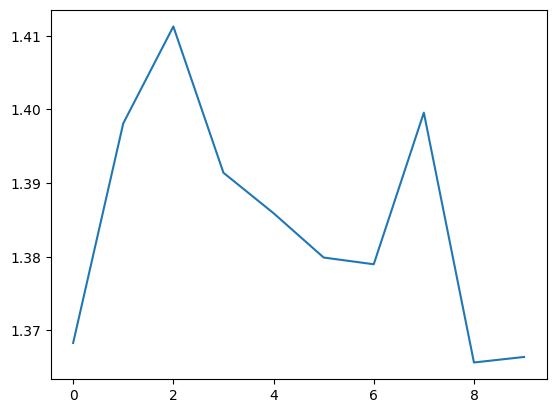

In [ ]:
plt.plot(cost_func_store, label='Cost function value')

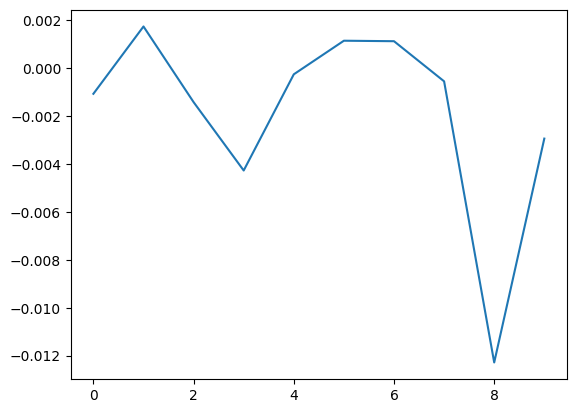

In [ ]:
gradients_values11 = []

for i in np.arange(10):
    epoch = i + 1

    gradients = np.load(f'./vn_net_gradients/gradients_epoch{epoch}.npy')
    gradients_values11.append(gradients[1][1])

plt.plot(gradients_values11, label='Gradients value')

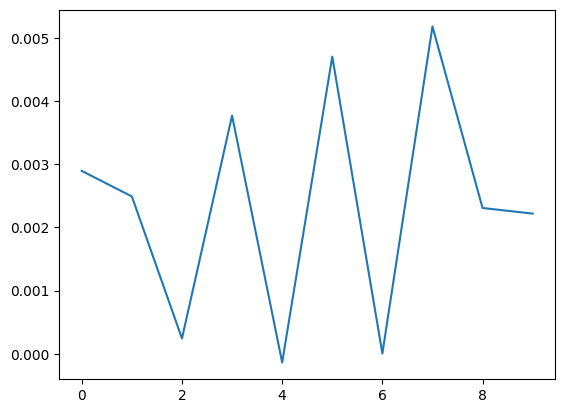

In [ ]:
gradients_values11 = []

for i in np.arange(10):
    epoch = i + 1

    gradients = np.load(f'./vn_net_gradients/gradients_qml_epoch{epoch}.npy')
    gradients_values11.append(gradients[1][1])

plt.plot(gradients_values11, label='Gradients value')

scalability

- scalingの実装開始、量子回路の深さ＆qubit数を増やすことを関数化
- gradientの変化文のスケールの変化を見る

## Circuit Comparison

In [1]:
import pennylane as qml
from qiskit import QuantumCircuit
from qiskit import transpile

import numpy as np

num_wires = 4
num_shots = 100

# PennyLane circuit
dev = qml.device('default.qubit', wires=num_wires, shots=num_shots)

@qml.qnode(dev)
def pennylane_circuit(param):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.PauliZ(wires=0)
    qml.PauliX(wires=0)
    qml.PauliY(wires=1)
    qml.RY(param[0], wires=0)
    qml.RX(param[1], wires=1)
    qml.CZ(wires=[0, 1])
    qml.RZ(param[2], wires=1)
    qml.CZ(wires=[1, 0])
    qml.RX(param[3], wires=1)
    qml.RY(param[4], wires=1)
    qml.RY(param[5], wires=0)
    qml.RZ(param[6], wires=0)
    qml.RZ(param[7], wires=1)
    qml.RZ(param[8], wires=0)
    return [qml.sample(qml.PauliZ(i)) for i in range(num_wires)]

# Qiskit circuit
def qiskit_circuit(param):
    qc = QuantumCircuit(num_wires, num_wires)
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    qc.z(0)
    qc.x(0)
    qc.y(1)
    qc.ry(param[0], 0)
    qc.rx(param[1], 1)
    qc.cz(0, 1)
    qc.rz(param[2], 1)
    qc.cz(1, 0)
    qc.rx(param[3], 1)
    qc.ry(param[4], 1)
    qc.ry(param[5], 0)
    qc.rz(param[6], 0)
    qc.rz(param[7], 1)
    qc.rz(param[8], 0)
    for i in range(num_wires):
        qc.measure(i, i)
    return qc

def measure_unified(param):
    # PennyLane circuit
    pennylane_results = pennylane_circuit(param)
    
    # Convert PennyLane results to bitstrings
    pennylane_bitstrings = [''.join(['1' if r == 1 else '0' for r in shot]) for shot in zip(*pennylane_results)]
    pennylane_counts = {bitstring: pennylane_bitstrings.count(bitstring) for bitstring in set(pennylane_bitstrings)}
    
    # Qiskit circuit
    qiskit_qc = qiskit_circuit(param)
    simulator = AerSimulator(method='statevector')
    compiled_circuit = transpile(qiskit_qc, simulator)
    job = simulator.run(compiled_circuit, shots=num_shots)
    qiskit_result = job.result()
    qiskit_counts = qiskit_result.get_counts(compiled_circuit)
    
    return {
        "pennylane": pennylane_counts,
        "qiskit": qiskit_counts
    }

# Example usage
param = np.array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864, 0.15599452, 0.05808361, 0.86617615, 0.60111501])
result = measure_unified(param)
print(result)
# Evaluate von Neumann entropy using its analytical forumla

# ignore the division by zero
np.seterr(divide = 'ignore')

# quantum relative entropy
H_rho = np.real(np.trace(rho_test @ (sc.linalg.logm(rho_test) - sc.linalg.logm(sigma))))

np.seterr(divide = 'warn')

# print the result
print(np.log(N)-H_rho)
class neural_function(nn.Module):
    def __init__(self,dimension,hidden_layer):
        super(neural_function, self).__init__()

        self.dimension = dimension
        self.hidden_layer = hidden_layer
        self.lin1 = nn.Linear(self.dimension, self.hidden_layer)
        self.lin_end = nn.Linear(self.hidden_layer, 1)

    def forward(self, input):
        y = torch.sigmoid(self.lin1(input.float()))
        y = self.lin_end(y)

        return y

NameError: name 'AerSimulator' is not defined

In [5]:
import time
qubits = 10
num_wires = 2 * qubits
num_layers = qubits
N = 2 ** qubits
seed = 42
num_shots = 100

device = qml.device("default.qubit", wires=num_wires, shots=num_shots)
@qml.qnode(device)
def measure_rho(param, qubits, ratio_imprim=0.8, pauli_gates=['PauliX', 'PauliY', 'PauliZ'], rotations=[qml.RX, qml.RY, qml.RZ], seed=None):
    if seed:
        np.random.seed(seed)

    obj_wires = range(qubits)   
    num_qubits = len(obj_wires) * 2
    rng = np.random.default_rng(seed)

    num_gates = len(obj_wires) * len(pauli_gates)
    qml.Hadamard(wires=0)
    for i in range(num_gates):
        if rng.random() < ratio_imprim:
            wires = rng.choice(list(np.arange(num_qubits)), size=2, replace=False)
            qml.CNOT(wires=wires)
        else:
            gate_choice = rng.choice(pauli_gates)
            wire = rng.choice(obj_wires)
            if gate_choice == 'PauliX':
                qml.PauliX(wires=wire)
            elif gate_choice == 'PauliY':
                qml.PauliY(wires=wire)
            elif gate_choice == 'PauliZ':
                qml.PauliZ(wires=wire)

    qml.RandomLayers(param, wires=obj_wires, rotations=rotations)

    result = [qml.sample(qml.PauliZ(i)) for i in range(len(obj_wires))]
    return result

param = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))

class neural_function(nn.Module):
    def __init__(self,dimension,hidden_layer):
        super(neural_function, self).__init__()

        self.dimension = dimension
        self.hidden_layer = hidden_layer
        self.lin1 = nn.Linear(self.dimension, self.hidden_layer)
        self.lin_end = nn.Linear(self.hidden_layer, 1)

    def forward(self, input):
        y = torch.sigmoid(self.lin1(input.float()))
        y = self.lin_end(y)

        return y

In [6]:
@qml.qnode(device)
def measure_rho(param, qubits, ratio_imprim=0.8, pauli_gates=['PauliX', 'PauliY', 'PauliZ'], rotations=[qml.RX, qml.RY, qml.RZ], seed=None):
    if seed:
        np.random.seed(seed)

    obj_wires = range(qubits)   
    num_qubits = len(obj_wires) * 2
    rng = np.random.default_rng(seed)

    num_gates = len(obj_wires) * len(pauli_gates)
    qml.Hadamard(wires=0)

    # まとめて乱数生成を行い、適切にスライスして使用
    random_values = rng.random(3 * num_gates)  # 必要な乱数の合計

    random_choices = random_values[:num_gates]  # ratio_imprimと比較する乱数
    gate_indices = (random_values[num_gates:2 * num_gates] * len(pauli_gates)).astype(int)  # ゲートのインデックス
    wire_indices = (random_values[2 * num_gates:3 * num_gates] * len(obj_wires)).astype(int)  # ワイヤーのインデックス
    cnot_wires = rng.choice(list(np.arange(num_qubits)), size=(num_gates, 2), replace=True)  # CNOT用のワイヤーペア

    gate_choices = [pauli_gates[i] for i in gate_indices]
    wire_choices = [obj_wires[i] for i in wire_indices]

    for i in range(num_gates):
        if random_choices[i] < ratio_imprim:
            qml.CNOT(wires=cnot_wires[i])
        else:
            if gate_choices[i] == 'PauliX':
                qml.PauliX(wires=wire_choices[i])
            elif gate_choices[i] == 'PauliY':
                qml.PauliY(wires=wire_choices[i])
            elif gate_choices[i] == 'PauliZ':
                qml.PauliZ(wires=wire_choices[i])

    qml.RandomLayers(param, wires=obj_wires, rotations=rotations)

    result = [qml.sample(qml.PauliZ(i)) for i in range(len(obj_wires))]
    return result

param = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))
time1 = time.time()
result = measure_rho(param, qubits, seed=seed)
time2 = time.time()
print("Execution time:", time2 - time1)

Execution time: 0.5945560932159424
